In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plotting style 
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [5]:
# Load data
df = pd.read_csv('../data/Imputing Rationales.csv')

# Basic overview
print(f"Total observations: {len(df)}")
print(f"{len(df.columns)} Columns: {df.columns.tolist()}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1e6:.2f} MB")
print(f"Date range: {df['ProxySeason'].min()} - {df['ProxySeason'].max()}")
print(f"Unique investigators: {df['investor_id'].nunique()}")
print(f"Unique companies: {df['pid'].nunique()}")
print(f"Unique meetings: {df['meeting_id'].nunique()}")

df.head()

Total observations: 3470442
70 Columns: ['investor_id', 'ProxySeason', 'pid', 'meeting_id', 'N_Meetings_Dir', 'N_Meetings_Rat', 'frac_vote_against', 'ind_dissent', 'boardstructure', 'diversity', 'indep', 'tenure', 'governance', 'combined_ceo_chairman', 'esg_csr', 'responsiveness', 'attendance', 'compensation', 'busyness', 'norat_misc', 'European', 'North_America', 'ROW', 'Country', 'US', 'Robo_Voter_ISS', 'Robo_Voter_GL', 'Robo_Voter', 'ProMgmt', 'Pension', 'Fund_manager', 'Other_investors', 'N_Meetings', 'N_dissent', 'Per_Independent', 'AvTenure', 'AvBusy', 'CEO_Duality', 'Per_female', 'D_Per_female', 'D_AvTenure', 'D_Independent', 'D_Busy', 'E_Index', 'E_Index_nomissing', 'Dissent', 'Contentious_ISS', 'Contentious_GL', 'ln_MktCap', 'ROA', 'Mkt_to_Book', 'Dividends', 'Lev', 'InstOwn_Perc', 'ffi', 'AdjEBITDA', 'alpha_mm', 'alpha_4f', 'TSR', 'boardstructure_tc', 'diversity_tc', 'indep_tc', 'tenure_tc', 'governance_tc', 'combined_ceo_chairman_tc', 'esg_csr_tc', 'responsiveness_tc', 'atte

,investor_id,ProxySeason,pid,meeting_id,N_Meetings_Dir,N_Meetings_Rat,frac_vote_against,ind_dissent,boardstructure,diversity,indep,tenure,governance,combined_ceo_chairman,esg_csr,responsiveness,attendance,compensation,busyness,norat_misc,European,North_America,ROW,Country,US,Robo_Voter_ISS,Robo_Voter_GL,Robo_Voter,ProMgmt,Pension,Fund_manager,Other_investors,N_Meetings,N_dissent,Per_Independent,AvTenure,AvBusy,CEO_Duality,Per_female,D_Per_female,D_AvTenure,D_Independent,D_Busy,E_Index,E_Index_nomissing,Dissent,Contentious_ISS,Contentious_GL,ln_MktCap,ROA,Mkt_to_Book,Dividends,Lev,InstOwn_Perc,ffi,AdjEBITDA,alpha_mm,alpha_4f,TSR,boardstructure_tc,diversity_tc,indep_tc,tenure_tc,governance_tc,combined_ceo_chairman_tc,esg_csr_tc,responsiveness_tc,attendance_tc,compensation_tc,busyness_tc
0,2,2014,44,84036,1377,356,0.0833,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,1,0,0,2,0,0,0,0,0,0,1,0,1504,791,0.8333,11.1750,1.7500,1.0000,0.1670,-0.0130,0.6250,0.0128,-0.1346,1.0000,1.0000,0.0338,0.0000,1.0000,11.8164,0.0413,1.6392,0.0151,0.3013,0.7072,7.0000,-0.0154,0.0100,0.0109,0.9267,0.0000,0.0000,0.1333,0.0000,0.0667,0.2000,0.0000,0.0667,0.0667,0.4667,0.0000
1,2,2014,184,80726,1377,356,0.1818,1,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0,2,0,0,0,0,0,0,1,0,1504,791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0234,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,0.8851,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.2857,0.2857,0.0000,0.2857,0.0000,0.0000,0.0000,0.0000,0.1429
2,2,2014,168,82137,1377,356,0.2500,1,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0,2,0,0,0,0,0,0,1,0,1504,791,0.9231,8.6923,1.5385,1.0000,0.2310,0.0000,1.0000,0.0000,-0.0769,3.0000,3.0000,0.0324,0.0000,0.0000,10.5392,0.0987,4.3402,0.0277,0.3543,0.8166,10.0000,0.4734,0.0029,0.0059,0.3624,0.1333,0.0000,0.2667,0.2000,0.0667,0.3333,0.0000,0.0000,0.0000,0.0000,0.0000
3,2,2014,32,82100,1377,356,0.0909,1,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0,2,0,0,0,0,0,0,1,0,1504,791,0.9286,6.9357,1.8571,1.0000,0.3570,0.0070,-0.7903,-0.0195,-0.0390,0.0000,0.0000,0.0371,0.0000,0.0000,11.8539,0.0510,2.0843,0.0425,0.3415,0.4682,7.0000,0.0699,0.0103,0.0023,0.3521,0.0000,0.0000,0.2727,0.0909,0.0909,0.3636,0.0000,0.0000,0.0000,0.0909,0.0909
4,2,2014,37,82101,1377,356,0.1538,1,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0,2,0,0,0,0,0,0,1,0,1504,791,0.9231,9.7769,1.8462,1.0000,0.3080,0.0770,-0.5692,0.0000,-0.3846,0.0000,0.0000,0.0507,0.0000,0.0000,11.7505,0.0903,4.2015,0.0272,0.3825,0.6898,1.0000,0.0628,0.0033,-0.0015,0.2609,0.0000,0.0000,0.3636,0.0909,0.1818,0.2727,0.0000,0.0000,0.0000,0.0000,0.0909


In [6]:
# Define key variables
TARGET_LABELS = ['diversity', 'indep', 'tenure', 'busyness', 'combined_ceo_chairman']
ALL_RATIONALES = ['diversity', 'boardstructure', 'indep', 'tenure', 'governance', 
                  'combined_ceo_chairman', 'esg_csr', 'responsiveness', 'attendance', 
                  'compensation', 'busyness', 'norat_misc']
REQUIRED_FEATURES = {'diversity': ['Per_female', 'D_Per_female'], 
                    'tenure': ['AvTenure', 'D_AvTenure'],    
                    'indep': ['Per_Independent', 'D_Independent']
                    }

print("DISSENT DISTRIBUTION")
print(f"Total dissenting votes (ind_dissent=1): {df['ind_dissent'].sum():,}")
print(f"Dissent rate: {df['ind_dissent'].mean():.2%}")
print(f"Total votes: {len(df):,}")
print(f" - For votes (ind_dissent=0): {(df['ind_dissent']==0).sum():,}")
print(f" - Against votes (ind_dissent=1): {(df['ind_dissent']==1).sum():,}")

DISSENT DISTRIBUTION
Total dissenting votes (ind_dissent=1): 993,401
Dissent rate: 28.62%
Total votes: 3,470,442
 - For votes (ind_dissent=0): 2,477,041
 - Against votes (ind_dissent=1): 993,401


In [7]:
# RATIONALE DISCLOSURE ANALYSIS

df['has_rationale'] = df[ALL_RATIONALES].notna().any(axis=1)

print(f"Observations with at least one rationale: {df['has_rationale'].sum():,}")
print(f"Overall disclosure rate: {df['has_rationale'].mean():.2%}")

# Among dissenting votes only
dissent_mask = df['ind_dissent'] == 1
print(f"\nAmong dissenting votes (ind_dissent=1):")
print(f"  - With rationale: {df.loc[dissent_mask, 'has_rationale'].sum():,}")
print(f"  - Without rationale: {(~df.loc[dissent_mask, 'has_rationale']).sum():,}")
print(f"  - Disclosure rate: {df.loc[dissent_mask, 'has_rationale'].mean():.2%}")

Observations with at least one rationale: 162,797
Overall disclosure rate: 4.69%

Among dissenting votes (ind_dissent=1):
  - With rationale: 162,797
  - Without rationale: 830,604
  - Disclosure rate: 16.39%


In [8]:
# Calculate investor-level statistics
investor_stats = df.groupby('investor_id').agg({
    'meeting_id': 'count',
    'ind_dissent': 'sum',
    'has_rationale': 'sum'
}).rename(columns={
    'meeting_id': 'N_Meetings',
    'ind_dissent': 'N_dissent',
    'has_rationale': 'N_Meetings_Rat'
})

print("\n" + "="*80)
print("INVESTOR-LEVEL STATISTICS")
print("="*80)
print(f"Total investors: {len(investor_stats):,}")
print(f"Non-disclosers (N_Meetings_Rat = 0): {(investor_stats['N_Meetings_Rat'] == 0).sum():,}")
print(f"Disclosers (N_Meetings_Rat > 0): {(investor_stats['N_Meetings_Rat'] > 0).sum():,}")

print("\nInvestor statistics:")
print(investor_stats.describe())



INVESTOR-LEVEL STATISTICS
Total investors: 1,603
Non-disclosers (N_Meetings_Rat = 0): 1,363
Disclosers (N_Meetings_Rat > 0): 240

Investor statistics:
       N_Meetings  N_dissent  N_Meetings_Rat
count   1603.0000  1603.0000       1603.0000
mean    2164.9669   619.7137        101.5577
std     4465.2877  1667.5336        714.4610
min        1.0000     0.0000          0.0000
25%      156.5000     7.0000          0.0000
50%      465.0000    55.0000          0.0000
75%     1688.5000   325.5000          0.0000
max    31442.0000 18034.0000      13991.0000


In [9]:
# Test different filter thresholds
print("\n" + "="*80)
print("FILTER THRESHOLD ANALYSIS")
print("="*80)

# Merge investor stats back to main df
df_with_stats = df.merge(investor_stats, left_on='investor_id', right_index=True, suffixes=('', '_calc'))

# Test different thresholds
thresholds = [0, 5, 10, 20, 50]
results = []

for min_rat in thresholds:
    for min_dissent in thresholds:
        # Apply filters
        mask = (df_with_stats['N_Meetings_Rat'] >= min_rat) & \
               (df_with_stats['N_dissent'] >= min_dissent) & \
               (df_with_stats['ind_dissent'] == 1)

        filtered = df_with_stats[mask]

        results.append({
            'min_N_Meetings_Rat': min_rat,
            'min_N_dissent': min_dissent,
            'n_observations': len(filtered),
            'n_investors': filtered['investor_id'].nunique(),
            'n_labeled': filtered['has_rationale'].sum(),
            'n_unlabeled': (~filtered['has_rationale']).sum(),
            'label_rate': filtered['has_rationale'].mean()
        })

threshold_df = pd.DataFrame(results)



FILTER THRESHOLD ANALYSIS


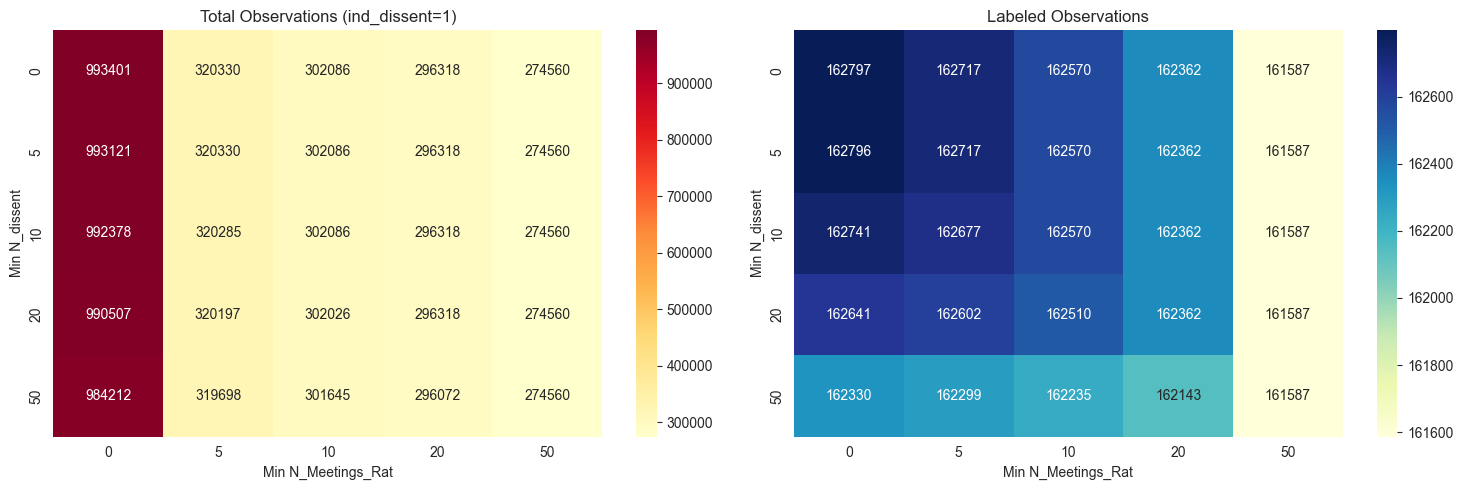

In [10]:
# Visualize threshold impact
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Sample size by thresholds
pivot_obs = threshold_df.pivot(index='min_N_dissent', columns='min_N_Meetings_Rat', values='n_observations')
sns.heatmap(pivot_obs, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[0])
axes[0].set_title('Total Observations (ind_dissent=1)')
axes[0].set_xlabel('Min N_Meetings_Rat')
axes[0].set_ylabel('Min N_dissent')

# Plot 2: Labeled observations
pivot_labeled = threshold_df.pivot(index='min_N_dissent', columns='min_N_Meetings_Rat', values='n_labeled')
sns.heatmap(pivot_labeled, annot=True, fmt='.0f', cmap='YlGnBu', ax=axes[1])
axes[1].set_title('Labeled Observations')
axes[1].set_xlabel('Min N_Meetings_Rat')
axes[1].set_ylabel('Min N_dissent')

plt.tight_layout()
plt.show()

In [11]:
# Apply recommended filters for subsequent analysis
MIN_RAT = 5
MIN_DISSENT = 5

df_filtered = df_with_stats[
    (df_with_stats['N_Meetings_Rat'] >= MIN_RAT) &
    (df_with_stats['N_dissent'] >= MIN_DISSENT) &
    (df_with_stats['ind_dissent'] == 1)
].copy()

print("="*80)
print(f"FILTERED DATASET (N_Meetings_Rat>={MIN_RAT}, N_dissent>={MIN_DISSENT}, ind_dissent=1)")
print("="*80)
print(f"Total observations: {len(df_filtered):,}")
print(f"Unique investors: {df_filtered['investor_id'].nunique():,}")
print(f"Labeled observations: {df_filtered['has_rationale'].sum():,}")
print(f"Unlabeled observations: {(~df_filtered['has_rationale']).sum():,}")
print(f"Label rate: {df_filtered['has_rationale'].mean():.2%}")

FILTERED DATASET (N_Meetings_Rat>=5, N_dissent>=5, ind_dissent=1)
Total observations: 320,330
Unique investors: 201
Labeled observations: 162,717
Unlabeled observations: 157,613
Label rate: 50.80%


Yearly statistics:
             N_dissent  N_disclosed  N_investors  disclosure_rate
ProxySeason                                                      
2014             24850         7196          116           0.2896
2015             26910         8844          137           0.3287
2016             28107         9703          142           0.3452
2017             32381        12536          153           0.3871
2018             37787        18384          157           0.4865
2019             42244        24786          161           0.5867
2020             41980        24761          166           0.5898
2021             44263        27655          157           0.6248
2022             41808        28852          146           0.6901


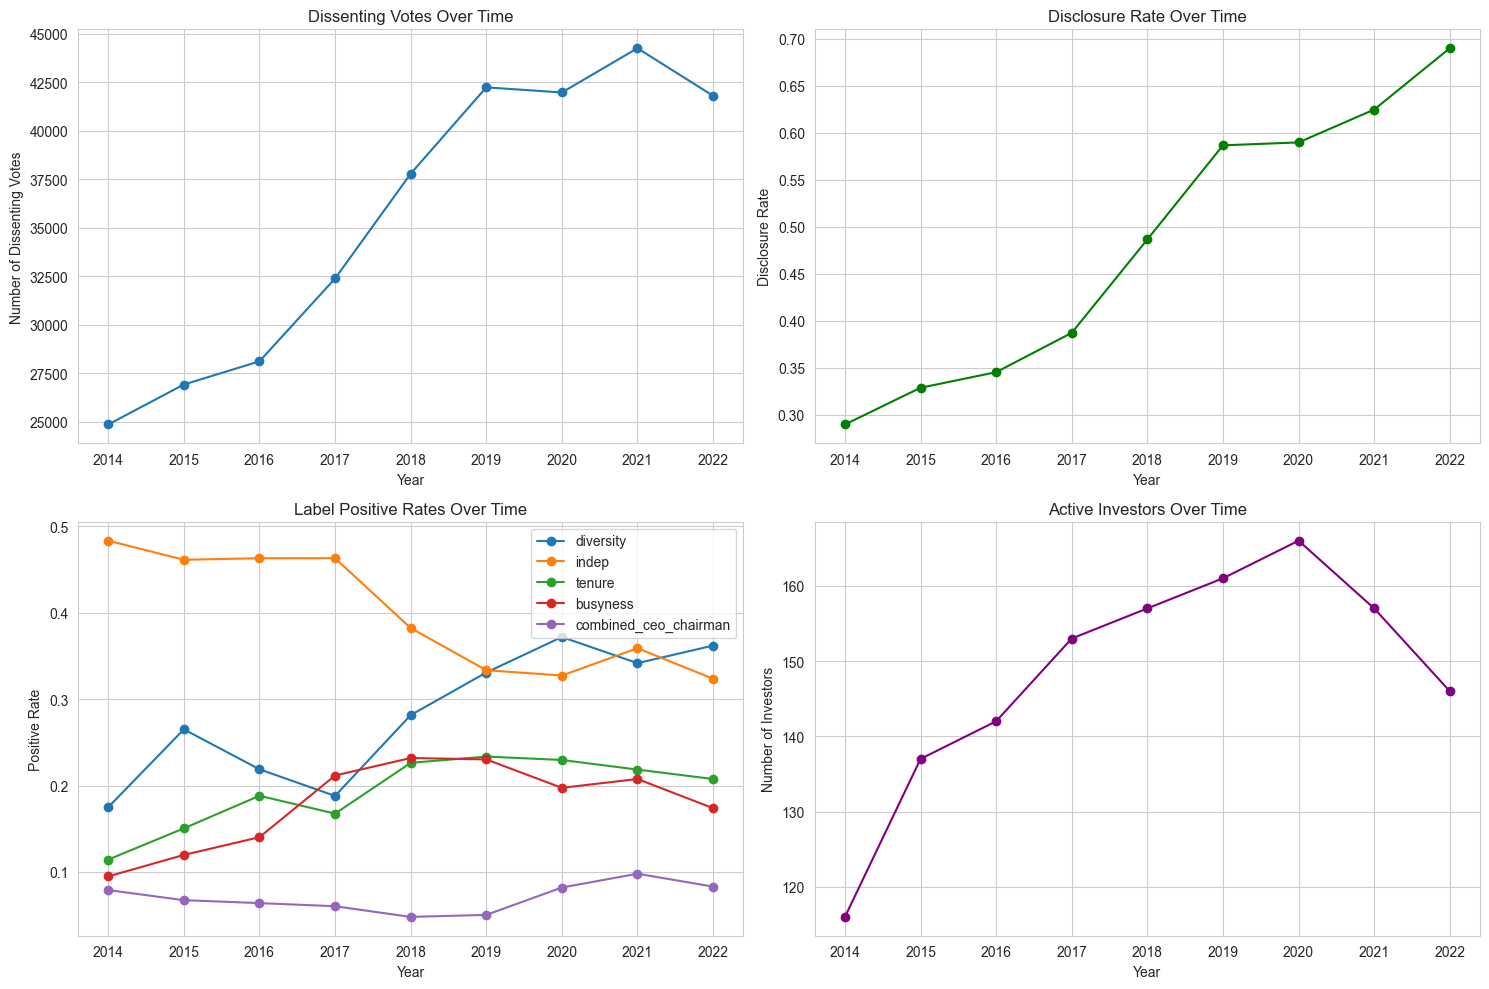

In [12]:
# TEMPORAL PATTERNS

# Overall trends by year
temporal = df_filtered.groupby('ProxySeason').agg({
    'meeting_id': 'count',
    'has_rationale': 'sum',
    'investor_id': 'nunique'
}).rename(columns={
    'meeting_id': 'N_dissent',
    'has_rationale': 'N_disclosed',
    'investor_id': 'N_investors'
})

temporal['disclosure_rate'] = temporal['N_disclosed'] / temporal['N_dissent']

print("Yearly statistics:")
print(temporal)

# Plot temporal trends
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Dissent volume
axes[0, 0].plot(temporal.index, temporal['N_dissent'], marker='o')
axes[0, 0].set_title('Dissenting Votes Over Time')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Dissenting Votes')
axes[0, 0].grid(True)

# Disclosure rate
axes[0, 1].plot(temporal.index, temporal['disclosure_rate'], marker='o', color='green')
axes[0, 1].set_title('Disclosure Rate Over Time')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Disclosure Rate')
axes[0, 1].grid(True)

# Label popularity over time
label_temporal = []
for year in df_filtered['ProxySeason'].unique():
    year_data = df_filtered[df_filtered['ProxySeason'] == year]
    row = {'year': year}
    for label in TARGET_LABELS:
        labeled = year_data[year_data[label].notna()]
        if len(labeled) > 0:
            row[label] = labeled[label].mean()
    label_temporal.append(row)

label_temporal_df = pd.DataFrame(label_temporal).set_index('year').sort_index()

for label in TARGET_LABELS:
    if label in label_temporal_df.columns:
        axes[1, 0].plot(label_temporal_df.index, label_temporal_df[label], marker='o', label=label)

axes[1, 0].set_title('Label Positive Rates Over Time')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Positive Rate')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Number of investors
axes[1, 1].plot(temporal.index, temporal['N_investors'], marker='o', color='purple')
axes[1, 1].set_title('Active Investors Over Time')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Number of Investors')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

DIVERSITY:
----------------------------------------
Per_female: Missing rate = 15.64%
D_Per_female: Missing rate = 18.23%
Labeled observations: 162,717
Per_female distribution:
- When diversity=1: mean=0.1600, std=0.1068
- When diversity=0: mean=0.2207, std=0.1157


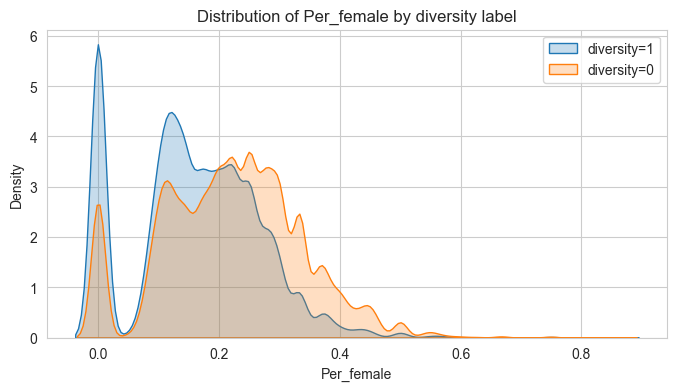

D_Per_female distribution:
- When diversity=1: mean=0.0218, std=0.0576
- When diversity=0: mean=0.0200, std=0.0568


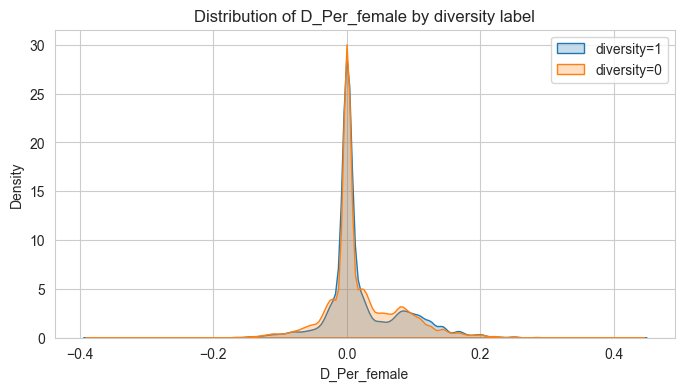

TENURE:
----------------------------------------
AvTenure: Missing rate = 15.64%
D_AvTenure: Missing rate = 18.23%
Labeled observations: 162,717
AvTenure distribution:
- When tenure=1: mean=10.2095, std=3.8711
- When tenure=0: mean=7.7537, std=4.5760


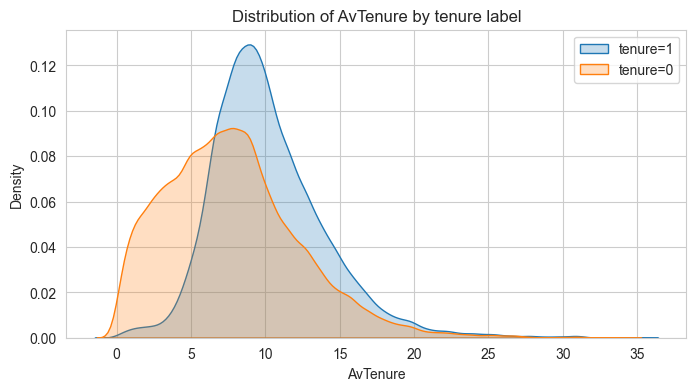

D_AvTenure distribution:
- When tenure=1: mean=-0.0147, std=1.3156
- When tenure=0: mean=0.1587, std=1.2573


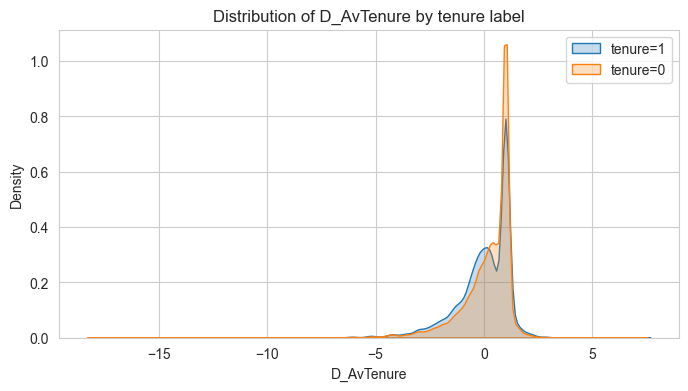

INDEP:
----------------------------------------
Per_Independent: Missing rate = 15.64%
D_Independent: Missing rate = 18.23%
Labeled observations: 162,717
Per_Independent distribution:
- When indep=1: mean=0.8492, std=0.0868
- When indep=0: mean=0.8569, std=0.0752


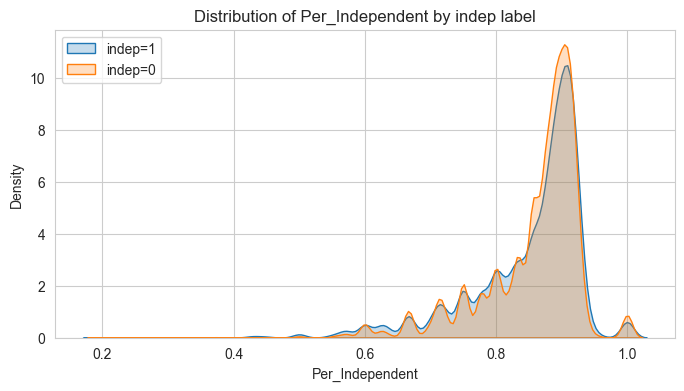

D_Independent distribution:
- When indep=1: mean=0.0035, std=0.0398
- When indep=0: mean=0.0031, std=0.0390


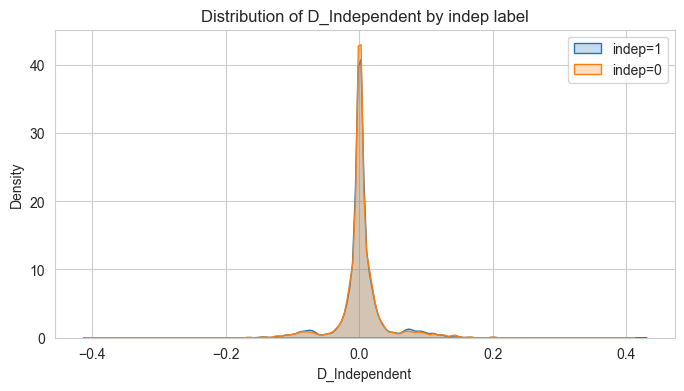

In [13]:
# REQUIRED FEATURE VALIDATION

for target, features in REQUIRED_FEATURES.items():
    print(f"{target.upper()}:")
    print("-" * 40)
    
    # Check feature availability
    for feat in features:
        if feat in df_filtered.columns:
            missing_rate = df_filtered[feat].isna().mean()
            print(f"{feat}: Missing rate = {missing_rate:.2%}")
        else:
            print(f"{feat}: NOT FOUND")
    
    # Check relationship with target (for labeled observations)
    if target in df_filtered.columns:
        labeled = df_filtered[df_filtered[target].notna()]
        if len(labeled) > 0 and all(f in labeled.columns for f in features):
            print(f"Labeled observations: {len(labeled):,}")
            
            # Compare feature distributions for positive vs negative labels
            for feat in features:
                if labeled[feat].notna().any():
                    pos = labeled[labeled[target] == 1][feat].dropna()
                    neg = labeled[labeled[target] == 0][feat].dropna()
                    
                    if len(pos) > 0 and len(neg) > 0:
                        print(f"{feat} distribution:")
                        print(f"- When {target}=1: mean={pos.mean():.4f}, std={pos.std():.4f}")
                        print(f"- When {target}=0: mean={neg.mean():.4f}, std={neg.std():.4f}")
                        
                        # Plot distributions
                        plt.figure(figsize=(8, 4))
                        sns.kdeplot(pos, label=f'{target}=1', shade=True)
                        sns.kdeplot(neg, label=f'{target}=0', shade=True)
                        plt.title(f'Distribution of {feat} by {target} label')
                        plt.xlabel(feat)
                        plt.legend()
                        plt.show()
                    else:
                        print(f"Not enough data to compare {feat} distributions.")
        else:
            print(f"No labeled observations with available features for {target}.")
    else:
        print(f"Target {target} not found in dataset.")

In [14]:
# IMBALANCE ASSESSMENT

for label in TARGET_LABELS:
    labeled = df_filtered[df_filtered[label].notna()]
    if len(labeled) > 0:
        imbalance_ratio = labeled[label].value_counts()
        print(f"{label}: {imbalance_ratio[1]} positive vs {imbalance_ratio[0]} negative")
        print(f"  Imbalance ratio: 1:{imbalance_ratio[0]/imbalance_ratio[1]:.1f}")

diversity: 50556 positive vs 112161 negative
  Imbalance ratio: 1:2.2
indep: 60513 positive vs 102204 negative
  Imbalance ratio: 1:1.7
tenure: 33745 positive vs 128972 negative
  Imbalance ratio: 1:3.8
busyness: 31370 positive vs 131347 negative
  Imbalance ratio: 1:4.2
combined_ceo_chairman: 11813 positive vs 150904 negative
  Imbalance ratio: 1:12.8


Observations with 0 missing features: 246233
Observations with 1-3 missing: 23568
Observations with 4+ missing: 50529


<Axes: >

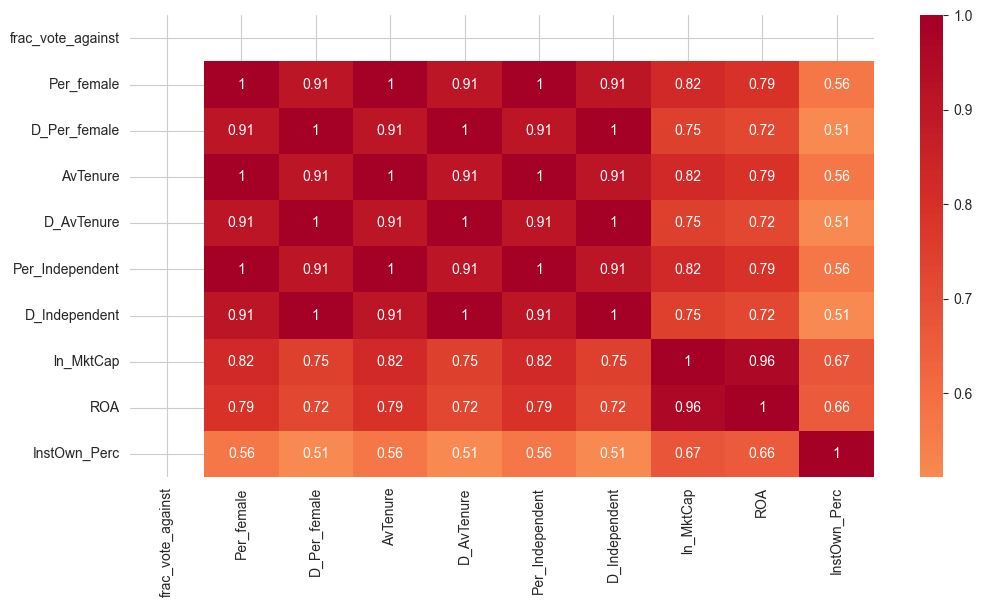

In [15]:
CORE_FEATURES = ['frac_vote_against', 'Per_female', 'D_Per_female', 
                 'AvTenure', 'D_AvTenure', 'Per_Independent', 'D_Independent',
                 'ln_MktCap', 'ROA', 'InstOwn_Perc']

# Check missingness patterns
missing_matrix = df_filtered[CORE_FEATURES].isna()
print("Observations with 0 missing features:", (~missing_matrix.any(axis=1)).sum())
print("Observations with 1-3 missing:", (missing_matrix.sum(axis=1).between(1,3)).sum())
print("Observations with 4+ missing:", (missing_matrix.sum(axis=1) >= 4).sum())

# Which features are almost always missing together?
missing_corr = missing_matrix.corr()
sns.heatmap(missing_corr, annot=True, cmap='RdYlGn_r', center=0)

Based on the matrix ^ we can identify closely correlated variables. Here we need to decide whether to create flags for missing 'clusters' of correlated variables or to impute them (impute all correlated variables together if one's missing).

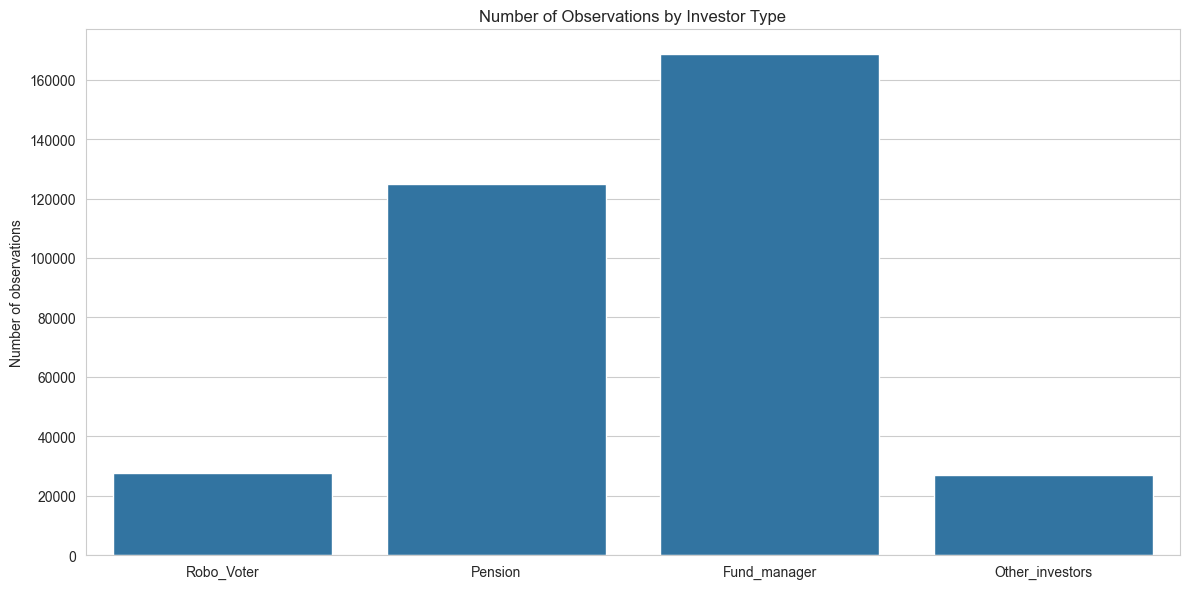

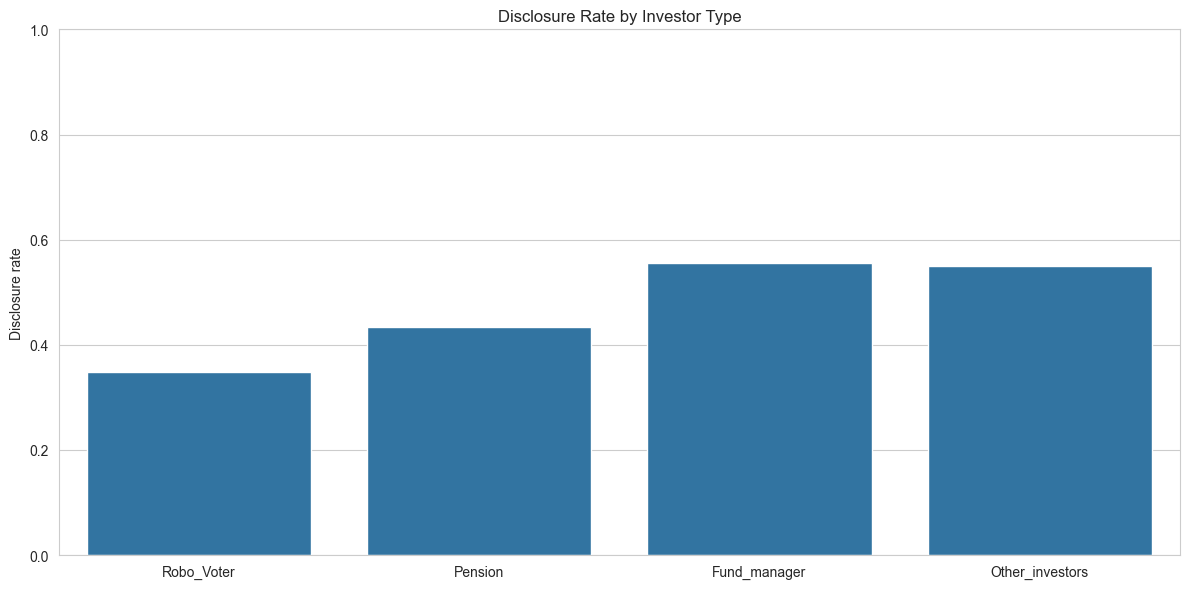

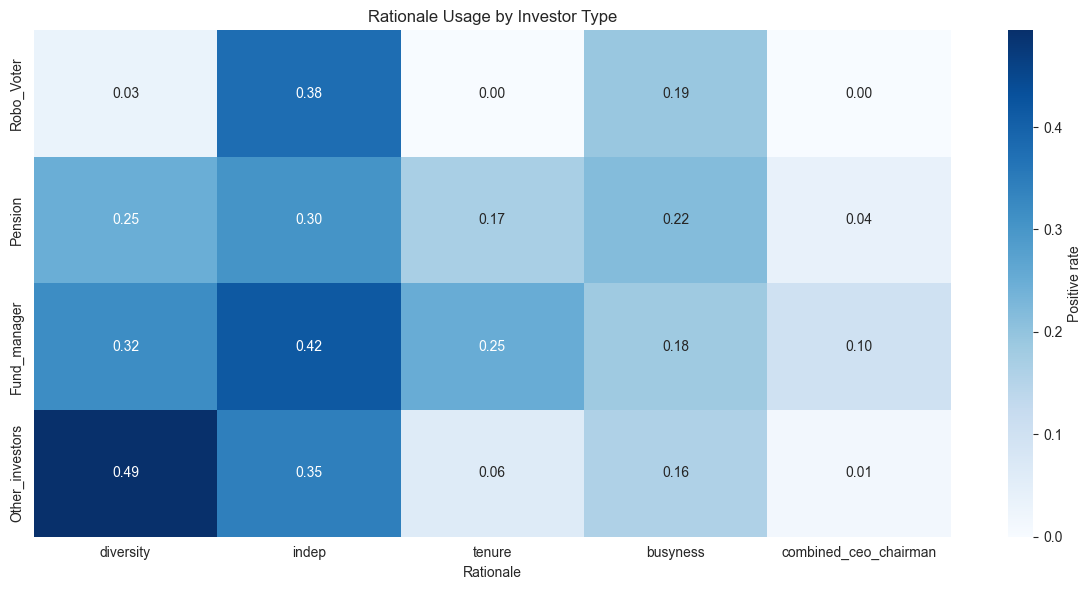

In [21]:
# INVESTOR TYPE ANALYSIS

summary_rows = []

for inv_type in investor_types:
    if inv_type not in df_filtered.columns:
        continue

    type_data = df_filtered[df_filtered[inv_type] == 1]

    row = {
        "investor_type": inv_type,
        "n_obs": len(type_data),
        "disclosure_rate": type_data["has_rationale"].mean()
    }

    for label in TARGET_LABELS:
        labeled = type_data[type_data[label].notna()]
        row[f"{label}_rate"] = labeled[label].mean() if len(labeled) > 0 else np.nan

    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)

plt.figure()
sns.barplot(
    data=summary_df,
    x="investor_type",
    y="n_obs"
)
plt.title("Number of Observations by Investor Type")
plt.ylabel("Number of observations")
plt.xlabel("")
plt.tight_layout()
plt.show()

plt.figure()
sns.barplot(
    data=summary_df,
    x="investor_type",
    y="disclosure_rate"
)
plt.title("Disclosure Rate by Investor Type")
plt.ylabel("Disclosure rate")
plt.xlabel("")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


label_rate_cols = [f"{l}_rate" for l in TARGET_LABELS]

heatmap_df = (
    summary_df
    .set_index("investor_type")[label_rate_cols]
    .rename(columns=lambda x: x.replace("_rate", ""))
)

plt.figure()
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar_kws={"label": "Positive rate"}
)

plt.title("Rationale Usage by Investor Type")
plt.ylabel("")
plt.xlabel("Rationale")
plt.tight_layout()
plt.show()


In [17]:
# Do US vs European vs ROW investors vote differently?

region_cols = ['US', 'European', 'North_America', 'ROW']
for region in region_cols:
    if region in df_filtered.columns:
        region_data = df_filtered[df_filtered[region] == 1]
        print(f"\n{region}: {len(region_data)} observations")
        
        # Check if label distributions differ by region
        for label in TARGET_LABELS[:3]:  # Just show top 3
            labeled = region_data[region_data[label].notna()]
            if len(labeled) > 50:
                print(f"  {label}: {labeled[label].mean():.2%}")


US: 181427 observations
  diversity: 45.41%
  indep: 23.94%
  tenure: 1.43%

European: 118029 observations
  diversity: 18.57%
  indep: 47.85%
  tenure: 37.10%

North_America: 197772 observations
  diversity: 43.94%
  indep: 26.81%
  tenure: 4.27%

ROW: 4529 observations
  diversity: 17.91%
  indep: 25.95%
  tenure: 23.53%


In [25]:
# REGION ANALYSIS

region_cols = ['US', 'European', 'North_America', 'ROW']

summary_rows = []

for region in region_cols:
    if region not in df_filtered.columns:
        continue

    region_data = df_filtered[df_filtered[region] == 1]

    row = {
        "region": region,
        "n_obs": len(region_data)
    }

    for label in TARGET_LABELS:
        labeled = region_data[region_data[label].notna()]
        row[f"{label}_rate"] = (
            labeled[label].mean() if len(labeled) > 50 else np.nan
        )

    summary_rows.append(row)

region_summary = pd.DataFrame(summary_rows)
region_summary


,region,n_obs,diversity_rate,indep_rate,tenure_rate,busyness_rate,combined_ceo_chairman_rate
0,US,181427,0.4541,0.2394,0.0143,0.2061,0.0038
1,European,118029,0.1857,0.4785,0.3710,0.1788,0.1363
2,North_America,197772,0.4394,0.2681,0.0427,0.2066,0.0086
3,ROW,4529,0.1791,0.2595,0.2353,0.1995,0.0800
